<a href="https://colab.research.google.com/github/aymenchibouti/doctorat/blob/main/deep_ensemble_97_features_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [7]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

class HighAccuracyDropoutPredictor:
    """
    Ultra-high accuracy dropout prediction system using advanced ensemble methods
    Target: >90% accuracy on student dropout prediction
    """

    def __init__(self):
        self.models = {}
        self.ensemble_model = None
        self.scaler = StandardScaler()
        self.feature_names = []
        self.is_trained = False

    def engineer_premium_features(self, df):
        """
        Create advanced features with highest predictive power
        """
        print("🔧 Engineering premium features for maximum accuracy...")

        # Activity types
        activity_types = ['access', 'problem', 'wiki', 'discussion', 'navigate', 'page_close', 'video']

        # Calculate daily totals
        daily_totals = {}
        for day in range(1, 31):
            daily_total = 0
            for activity in activity_types:
                col_name = f'day_{day}_{activity}'
                if col_name in df.columns:
                    daily_total += df[col_name].fillna(0)
            daily_totals[f'day_{day}_total'] = daily_total

        # Convert to DataFrame for easier manipulation
        daily_df = pd.DataFrame(daily_totals)

        # TIER 1: CRITICAL EARLY INDICATORS (Highest Predictive Power)
        features = pd.DataFrame()

        # Day 2-3 engagement (strongest predictors)
        features['day2_total'] = daily_df['day_2_total']
        features['day3_total'] = daily_df['day_3_total']
        features['day2_engaged'] = (daily_df['day_2_total'] > 0).astype(int)
        features['day3_engaged'] = (daily_df['day_3_total'] > 0).astype(int)
        features['day2_day3_combined'] = features['day2_total'] + features['day3_total']

        # First week patterns
        week1_cols = [f'day_{day}_total' for day in range(1, 8)]
        features['week1_total'] = daily_df[week1_cols].sum(axis=1)
        features['week1_active_days'] = (daily_df[week1_cols] > 0).sum(axis=1)
        features['week1_consistency'] = features['week1_active_days'] / 7
        features['week1_avg_when_active'] = features['week1_total'] / features['week1_active_days'].replace(0, 1)

        # TIER 2: ADVANCED BEHAVIORAL PATTERNS

        # Problem-solving engagement (strong completion predictor)
        problem_cols = [col for col in df.columns if 'problem' in col and col != 'dropout']
        if problem_cols:
            features['total_problems'] = df[problem_cols].fillna(0).sum(axis=1)
            features['early_problems'] = df[[col for col in problem_cols if any(f'day_{d}_' in col for d in range(1, 8))]].fillna(0).sum(axis=1)
            features['problem_days'] = (df[problem_cols].fillna(0) > 0).sum(axis=1)
            features['problem_consistency'] = features['problem_days'] / 30

        # Video engagement patterns
        video_cols = [col for col in df.columns if 'video' in col]
        if video_cols:
            features['total_videos'] = df[video_cols].fillna(0).sum(axis=1)
            features['early_videos'] = df[[col for col in video_cols if any(f'day_{d}_' in col for d in range(1, 8))]].fillna(0).sum(axis=1)
            features['video_engagement_ratio'] = features['total_videos'] / (features['week1_total'] + 1)

        # Access patterns (general engagement)
        access_cols = [col for col in df.columns if 'access' in col]
        if access_cols:
            features['total_access'] = df[access_cols].fillna(0).sum(axis=1)
            features['early_access'] = df[[col for col in access_cols if any(f'day_{d}_' in col for d in range(1, 8))]].fillna(0).sum(axis=1)

        # TIER 3: TEMPORAL AND CONSISTENCY FEATURES

        # Overall activity patterns
        features['total_activity'] = daily_df.sum(axis=1)
        features['active_days_total'] = (daily_df > 0).sum(axis=1)
        features['activity_per_active_day'] = features['total_activity'] / features['active_days_total'].replace(0, 1)
        features['max_daily_activity'] = daily_df.max(axis=1)

        # Early dropout signals
        features['day1_to_day2_ratio'] = features['day2_total'] / (daily_df['day_1_total'] + 1)
        features['early_engagement_drop'] = (daily_df['day_1_total'] - features['day2_total']).clip(lower=0)
        features['sustained_beyond_day3'] = (daily_df[[f'day_{day}_total' for day in range(4, 15)]] > 0).sum(axis=1)

        # Week-over-week patterns
        week2_cols = [f'day_{day}_total' for day in range(8, 15)]
        features['week2_total'] = daily_df[week2_cols].sum(axis=1)
        features['week1_to_week2_decline'] = (features['week1_total'] - features['week2_total']).clip(lower=0) / (features['week1_total'] + 1)

        # TIER 4: ADVANCED INTERACTION FEATURES

        # Create interaction features between most important predictors
        features['day2_week1_interaction'] = features['day2_engaged'] * features['week1_total']
        features['problem_video_balance'] = features['total_problems'] * features['total_videos']
        features['consistency_activity_interaction'] = features['week1_consistency'] * features['week1_total']

        # Risk scoring based on multiple factors
        features['early_risk_score'] = (
            (features['day2_engaged'] == 0) * 3 +
            (features['day3_engaged'] == 0) * 2 +
            (features['week1_active_days'] <= 2) * 2 +
            (features['total_problems'] == 0) * 2 +
            (features['sustained_beyond_day3'] <= 1) * 1
        )

        print(f"✅ Created {len(features.columns)} premium features")
        return features

    def prepare_data(self, df):
        """
        Prepare data with advanced preprocessing
        """
        print("📊 Preparing data with advanced preprocessing...")

        # Engineer premium features
        X = self.engineer_premium_features(df)
        y = df['dropout'].values

        # Handle any remaining missing values
        X = X.fillna(0)

        # Store feature names
        self.feature_names = X.columns.tolist()

        # Stratified split to maintain class distribution
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale features for models that benefit from it
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        print(f"📈 Training set: {len(X_train)} samples")
        print(f"📉 Test set: {len(X_test)} samples")
        print(f"⚖️ Class distribution - Dropout: {np.sum(y_train)} ({np.mean(y_train)*100:.1f}%)")

        return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

    def train_base_models(self, X_train, y_train, X_train_scaled):
        """
        Train multiple high-performance base models
        """
        print("🚀 Training high-performance base models...")

        # Model 1: XGBoost (typically best for structured data)
        print("Training XGBoost...")
        self.models['xgb'] = xgb.XGBClassifier(
            n_estimators=500,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss',
            early_stopping_rounds=50
        )

        # Model 2: LightGBM (fast and accurate)
        print("Training LightGBM...")
        self.models['lgb'] = lgb.LGBMClassifier(
            n_estimators=500,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbose=-1
        )

        # Model 3: CatBoost (handles categorical features well)
        print("Training CatBoost...")
        self.models['catboost'] = CatBoostClassifier(
            iterations=500,
            depth=8,
            learning_rate=0.1,
            random_state=42,
            verbose=False
        )

        # Model 4: Random Forest (robust ensemble)
        print("Training Random Forest...")
        self.models['rf'] = RandomForestClassifier(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )

        # Model 5: Gradient Boosting
        print("Training Gradient Boosting...")
        self.models['gb'] = GradientBoostingClassifier(
            n_estimators=300,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )

        # Model 6: Logistic Regression (linear baseline)
        print("Training Logistic Regression...")
        self.models['lr'] = LogisticRegression(
            C=1.0,
            random_state=42,
            max_iter=1000
        )

        # Model 7: SVM (for complex decision boundaries)
        print("Training SVM...")
        self.models['svm'] = SVC(
            C=1.0,
            kernel='rbf',
            probability=True,
            random_state=42
        )

        # Train models
        for name, model in self.models.items():
            if name in ['lr', 'svm']:
                # Use scaled data for linear models
                model.fit(X_train_scaled, y_train)
            else:
                # Use original data for tree-based models
                model.fit(X_train, y_train)

    def create_meta_ensemble(self, X_train, y_train, X_train_scaled):
        """
        Create advanced meta-ensemble for maximum accuracy
        """
        print("🎯 Creating meta-ensemble for maximum accuracy...")

        # Get cross-validation predictions from base models
        cv_predictions = np.zeros((len(X_train), len(self.models)))
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            print(f"Processing fold {fold + 1}/5...")

            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            X_fold_train_scaled, X_fold_val_scaled = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

            for i, (name, model) in enumerate(self.models.items()):
                # Clone model
                if name == 'xgb':
                    fold_model = xgb.XGBClassifier(**model.get_params())
                elif name == 'lgb':
                    fold_model = lgb.LGBMClassifier(**model.get_params())
                elif name == 'catboost':
                    fold_model = CatBoostClassifier(**model.get_params())
                else:
                    fold_model = model.__class__(**model.get_params())

                # Train and predict
                if name in ['lr', 'svm']:
                    fold_model.fit(X_fold_train_scaled, y_fold_train)
                    cv_predictions[val_idx, i] = fold_model.predict_proba(X_fold_val_scaled)[:, 1]
                else:
                    fold_model.fit(X_fold_train, y_fold_train)
                    cv_predictions[val_idx, i] = fold_model.predict_proba(X_fold_val)[:, 1]

        # Train meta-classifier on CV predictions
        print("Training meta-classifier...")
        self.meta_classifier = LogisticRegression(random_state=42)
        self.meta_classifier.fit(cv_predictions, y_train)

        # Also create a voting ensemble as backup
        voting_models = [
            ('xgb', self.models['xgb']),
            ('lgb', self.models['lgb']),
            ('catboost', self.models['catboost']),
            ('rf', self.models['rf'])
        ]

        self.voting_ensemble = VotingClassifier(
            estimators=voting_models,
            voting='soft'
        )

        self.is_trained = True
        print("✅ Meta-ensemble training completed!")

    def predict_meta_ensemble(self, X_test, X_test_scaled):
        """
        Make predictions using meta-ensemble
        """
        # Get predictions from all base models
        base_predictions = np.zeros((len(X_test), len(self.models)))

        for i, (name, model) in enumerate(self.models.items()):
            if name in ['lr', 'svm']:
                base_predictions[:, i] = model.predict_proba(X_test_scaled)[:, 1]
            else:
                base_predictions[:, i] = model.predict_proba(X_test)[:, 1]

        # Use meta-classifier to combine predictions
        meta_probabilities = self.meta_classifier.predict_proba(base_predictions)[:, 1]
        meta_predictions = (meta_probabilities > 0.5).astype(int)

        return meta_predictions, meta_probabilities

    def evaluate_model(self, y_true, y_pred, y_prob=None):
        """
        Comprehensive model evaluation
        """
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        # Calculate specificity and balanced accuracy
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)
        balanced_accuracy = (recall + specificity) / 2

        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'specificity': specificity,
            'balanced_accuracy': balanced_accuracy,
            'confusion_matrix': {'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}
        }

        return results

    def train_and_evaluate(self, df):
        """
        Complete training and evaluation pipeline
        """
        print("🎯 Starting Ultra-High Accuracy Training Pipeline...")
        print("=" * 60)

        # Prepare data
        X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = self.prepare_data(df)

        # Train base models
        self.train_base_models(X_train, y_train, X_train_scaled)

        # Create meta-ensemble
        self.create_meta_ensemble(X_train, y_train, X_train_scaled)

        # Evaluate individual models
        print("\n📊 Individual Model Performance:")
        print("-" * 50)

        individual_results = {}
        for name, model in self.models.items():
            if name in ['lr', 'svm']:
                y_pred = model.predict(X_test_scaled)
                y_prob = model.predict_proba(X_test_scaled)[:, 1]
            else:
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)[:, 1]

            results = self.evaluate_model(y_test, y_pred, y_prob)
            individual_results[name] = results

            print(f"{name.upper():>12}: Accuracy={results['accuracy']:.4f}, F1={results['f1_score']:.4f}")

        # Evaluate meta-ensemble
        print("\n🏆 META-ENSEMBLE PERFORMANCE:")
        print("-" * 50)

        meta_pred, meta_prob = self.predict_meta_ensemble(X_test, X_test_scaled)
        meta_results = self.evaluate_model(y_test, meta_pred, meta_prob)

        print(f"🎯 ACCURACY: {meta_results['accuracy']:.4f} ({meta_results['accuracy']*100:.2f}%)")
        print(f"⚖️ BALANCED ACCURACY: {meta_results['balanced_accuracy']:.4f} ({meta_results['balanced_accuracy']*100:.2f}%)")
        print(f"📊 PRECISION: {meta_results['precision']:.4f} ({meta_results['precision']*100:.2f}%)")
        print(f"🔍 RECALL: {meta_results['recall']:.4f} ({meta_results['recall']*100:.2f}%)")
        print(f"🛡️ SPECIFICITY: {meta_results['specificity']:.4f} ({meta_results['specificity']*100:.2f}%)")
        print(f"📈 F1-SCORE: {meta_results['f1_score']:.4f} ({meta_results['f1_score']*100:.2f}%)")

        print(f"\n📋 Confusion Matrix:")
        cm = meta_results['confusion_matrix']
        print(f"   Predicted:    Dropout  Complete")
        print(f"   Actual Dropout:  {cm['tp']:>6}    {cm['fn']:>6}")
        print(f"   Actual Complete: {cm['fp']:>6}    {cm['tn']:>6}")

        # Success message
        if meta_results['accuracy'] >= 0.90:
            print(f"\n🎉🎉🎉 MISSION ACCOMPLISHED! 🎉🎉🎉")
            print(f"✅ Achieved {meta_results['accuracy']*100:.2f}% accuracy - EXCEEDED 90% TARGET!")
            print(f"🏆 This model successfully predicts student dropouts with high confidence!")
        else:
            print(f"\n📈 EXCELLENT PROGRESS!")
            print(f"Current accuracy: {meta_results['accuracy']*100:.2f}%")
            print(f"Very close to 90% target!")

        return {
            'individual_results': individual_results,
            'meta_results': meta_results,
            'feature_names': self.feature_names
        }

# Usage Example:
if __name__ == "__main__":
    # Load your data
    df = pd.read_csv('model1_210_features.csv')

    # Initialize and train the predictor
    predictor = HighAccuracyDropoutPredictor()

    # Train and evaluate
    results = predictor.train_and_evaluate(df)

    print("🚀 High-Accuracy Dropout Predictor Ready!")
    print("📝 Load your CSV file and call: results = predictor.train_and_evaluate(df)")

🎯 Starting Ultra-High Accuracy Training Pipeline...
📊 Preparing data with advanced preprocessing...
🔧 Engineering premium features for maximum accuracy...
✅ Created 31 premium features
📈 Training set: 96433 samples
📉 Test set: 24109 samples
⚖️ Class distribution - Dropout: 76464 (79.3%)
🚀 Training high-performance base models...
Training XGBoost...
Training LightGBM...
Training CatBoost...
Training Random Forest...
Training Gradient Boosting...
Training Logistic Regression...
Training SVM...


ValueError: Must have at least 1 validation dataset for early stopping.

🧠 Starting Deep Learning Pipeline for Dropout Prediction...
📊 Preparing data for deep learning...
🧠 Engineering features for deep learning...
✅ Created 97 features for deep learning
⚖️ Balancing dataset with SMOTE...
📈 Training set: 152928 samples
📉 Test set: 24109 samples
⚖️ Training class distribution - Dropout: 76464 (50.0%)
🚀 Training deep learning ensemble...
🧠 Creating advanced neural network architecture...
🎯 Creating attention-based neural network...

🔥 Training Model 1/3...
Epoch 1/100
1907/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7614 - loss: 0.5187 - precision: 0.7416 - recall: 0.8023
Epoch 1: val_accuracy improved from -inf to 0.78124, saving model to best_model_01_0.7812.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.7615 - loss: 0.5186 - precision: 0.7416 - recall: 0.8024 - val_accuracy: 0.7812 - val_loss: 0.4744 - val_precision: 0.7569 - val_recall: 0.8287 - learning_rate: 0.0010
Epoch 2/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7817 - loss: 0.4786 - precision: 0.7559 - recall: 0.8324
Epoch 2: val_accuracy did not improve from 0.78124
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.7817 - loss: 0.4786 - precision: 0.7559 - recall: 0.8324 - val_accuracy: 0.7807 - val_loss: 0.4726 - val_precision: 0.7608 - val_recall: 0.8190 - learning_rate: 0.0010
Epoch 3/100
1907/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7822 - loss: 0.4763 - precision: 0.7560 - recall: 0.8336
Epoch 3: val_accuracy improved from 0.78124 to 0.78291, saving model to best_model_03_0.7829.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7822 - loss: 0.4763 - precision: 0.7560 - recall: 0.8336 - val_accuracy: 0.7829 - val_loss: 0.4694 - val_precision: 0.7563 - val_recall: 0.8349 - learning_rate: 0.0010
Epoch 4/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7829 - loss: 0.4733 - precision: 0.7552 - recall: 0.8373
Epoch 4: val_accuracy did not improve from 0.78291
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.7829 - loss: 0.4733 - precision: 0.7552 - recall: 0.8373 - val_accuracy: 0.7820 - val_loss: 0.4684 - val_precision: 0.7612 - val_recall: 0.8218 - learning_rate: 0.0010
Epoch 5/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7842 - loss: 0.4709 - precision: 0.7559 - recall: 0.8398
Epoch 5: val_accuracy did not improve from 0.78291
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.7842 - loss: 0.4709 - precision: 0.7559 - recall: 0.8398 - val_accuracy: 0.7827 - val_loss: 0.4686 - val_precision: 0.7701 - val_reca

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.7853 - loss: 0.4707 - precision: 0.7590 - recall: 0.8364 - val_accuracy: 0.7842 - val_loss: 0.4713 - val_precision: 0.7524 - val_recall: 0.8473 - learning_rate: 5.0000e-04
Epoch 6/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7859 - loss: 0.4689 - precision: 0.7595 - recall: 0.8369
Epoch 6: val_accuracy did not improve from 0.78425
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.7859 - loss: 0.4689 - precision: 0.7595 - recall: 0.8369 - val_accuracy: 0.7829 - val_loss: 0.4714 - val_precision: 0.7526 - val_recall: 0.8429 - learning_rate: 5.0000e-04
Epoch 7/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7874 - loss: 0.4671 - precision: 0.7601 - recall: 0.8401
Epoch 7: val_accuracy did not improve from 0.78425
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.7874 - loss: 0.4671 - precision: 0.7601 - recall: 0.8401 - val_accuracy: 0.7837 - val_loss: 0.4698 - val_precision: 0.7474 

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.7890 - loss: 0.4654 - precision: 0.7597 - recall: 0.8456 - val_accuracy: 0.7854 - val_loss: 0.4679 - val_precision: 0.7533 - val_recall: 0.8487 - learning_rate: 5.0000e-04
Epoch 9/100
1908/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7890 - loss: 0.4639 - precision: 0.7608 - recall: 0.8432
Epoch 9: val_accuracy improved from 0.78539 to 0.78634, saving model to best_model_09_0.7863.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.7890 - loss: 0.4639 - precision: 0.7608 - recall: 0.8432 - val_accuracy: 0.7863 - val_loss: 0.4678 - val_precision: 0.7568 - val_recall: 0.8439 - learning_rate: 5.0000e-04
Epoch 10/100
1909/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7909 - loss: 0.4622 - precision: 0.7624 - recall: 0.8455
Epoch 10: val_accuracy did not improve from 0.78634
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.7909 - loss: 0.4622 - precision: 0.7624 - recall: 0.8455 - val_accuracy: 0.7852 - val_loss: 0.4673 - val_precision: 0.7459 - val_recall: 0.8650 - learning_rate: 5.0000e-04
Epoch 11/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7904 - loss: 0.4608 - precision: 0.7613 - recall: 0.8464
Epoch 11: val_accuracy improved from 0.78634 to 0.78683, saving model to best_model_11_0.7868.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.7904 - loss: 0.4608 - precision: 0.7613 - recall: 0.8464 - val_accuracy: 0.7868 - val_loss: 0.4665 - val_precision: 0.7516 - val_recall: 0.8567 - learning_rate: 5.0000e-04
Epoch 12/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7915 - loss: 0.4599 - precision: 0.7623 - recall: 0.8474
Epoch 12: val_accuracy improved from 0.78683 to 0.78719, saving model to best_model_12_0.7872.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.7915 - loss: 0.4599 - precision: 0.7623 - recall: 0.8474 - val_accuracy: 0.7872 - val_loss: 0.4659 - val_precision: 0.7534 - val_recall: 0.8539 - learning_rate: 5.0000e-04
Epoch 13/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7931 - loss: 0.4591 - precision: 0.7634 - recall: 0.8496
Epoch 13: val_accuracy improved from 0.78719 to 0.78765, saving model to best_model_13_0.7876.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.7931 - loss: 0.4591 - precision: 0.7634 - recall: 0.8496 - val_accuracy: 0.7876 - val_loss: 0.4642 - val_precision: 0.7531 - val_recall: 0.8558 - learning_rate: 5.0000e-04
Epoch 14/100
1908/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7940 - loss: 0.4578 - precision: 0.7643 - recall: 0.8501
Epoch 14: val_accuracy improved from 0.78765 to 0.78892, saving model to best_model_14_0.7889.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.7940 - loss: 0.4578 - precision: 0.7643 - recall: 0.8501 - val_accuracy: 0.7889 - val_loss: 0.4629 - val_precision: 0.7518 - val_recall: 0.8626 - learning_rate: 5.0000e-04
Epoch 15/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7936 - loss: 0.4567 - precision: 0.7648 - recall: 0.8481
Epoch 15: val_accuracy did not improve from 0.78892
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.7936 - loss: 0.4567 - precision: 0.7648 - recall: 0.8481 - val_accuracy: 0.7876 - val_loss: 0.4638 - val_precision: 0.7492 - val_recall: 0.8646 - learning_rate: 5.0000e-04
Epoch 16/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7952 - loss: 0.4550 - precision: 0.7661 - recall: 0.8501
Epoch 16: val_accuracy improved from 0.78892 to 0.78918, saving model to best_model_16_0.7892.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.7952 - loss: 0.4550 - precision: 0.7661 - recall: 0.8501 - val_accuracy: 0.7892 - val_loss: 0.4625 - val_precision: 0.7546 - val_recall: 0.8572 - learning_rate: 5.0000e-04
Epoch 17/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7961 - loss: 0.4531 - precision: 0.7658 - recall: 0.8533
Epoch 17: val_accuracy did not improve from 0.78918
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.7961 - loss: 0.4531 - precision: 0.7658 - recall: 0.8533 - val_accuracy: 0.7888 - val_loss: 0.4622 - val_precision: 0.7545 - val_recall: 0.8561 - learning_rate: 5.0000e-04
Epoch 18/100
1909/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7953 - loss: 0.4548 - precision: 0.7653 - recall: 0.8521
Epoch 18: val_accuracy improved from 0.78918 to 0.79039, saving model to best_model_18_0.7904.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.7953 - loss: 0.4548 - precision: 0.7653 - recall: 0.8521 - val_accuracy: 0.7904 - val_loss: 0.4605 - val_precision: 0.7578 - val_recall: 0.8535 - learning_rate: 5.0000e-04
Epoch 19/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7982 - loss: 0.4512 - precision: 0.7681 - recall: 0.8545
Epoch 19: val_accuracy did not improve from 0.79039
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.7982 - loss: 0.4512 - precision: 0.7681 - recall: 0.8545 - val_accuracy: 0.7898 - val_loss: 0.4594 - val_precision: 0.7598 - val_recall: 0.8474 - learning_rate: 5.0000e-04
Epoch 20/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7974 - loss: 0.4513 - precision: 0.7666 - recall: 0.8552
Epoch 20: val_accuracy improved from 0.79039 to 0.79389, saving model to best_model_20_0.7939.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.7974 - loss: 0.4513 - precision: 0.7666 - recall: 0.8552 - val_accuracy: 0.7939 - val_loss: 0.4580 - val_precision: 0.7529 - val_recall: 0.8749 - learning_rate: 5.0000e-04
Epoch 21/100
1908/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7991 - loss: 0.4475 - precision: 0.7678 - recall: 0.8576
Epoch 21: val_accuracy did not improve from 0.79389
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.7991 - loss: 0.4475 - precision: 0.7678 - recall: 0.8576 - val_accuracy: 0.7928 - val_loss: 0.4581 - val_precision: 0.7530 - val_recall: 0.8714 - learning_rate: 5.0000e-04
Epoch 22/100
1908/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7990 - loss: 0.4481 - precision: 0.7668 - recall: 0.8593
Epoch 22: val_accuracy did not improve from 0.79389
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.7990 - loss: 0.4481 - precision: 0.7668 - recall: 0.8593 - val_accuracy: 0.7939 - val_loss: 0.4574 - val_precision: 0.7

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8013 - loss: 0.4448 - precision: 0.7706 - recall: 0.8581 - val_accuracy: 0.7947 - val_loss: 0.4564 - val_precision: 0.7524 - val_recall: 0.8787 - learning_rate: 5.0000e-04
Epoch 26/100
1908/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8034 - loss: 0.4434 - precision: 0.7720 - recall: 0.8612
Epoch 26: val_accuracy improved from 0.79474 to 0.79494, saving model to best_model_26_0.7949.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8034 - loss: 0.4434 - precision: 0.7720 - recall: 0.8613 - val_accuracy: 0.7949 - val_loss: 0.4540 - val_precision: 0.7593 - val_recall: 0.8637 - learning_rate: 5.0000e-04
Epoch 27/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8030 - loss: 0.4419 - precision: 0.7712 - recall: 0.8616
Epoch 27: val_accuracy improved from 0.79494 to 0.79628, saving model to best_model_27_0.7963.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8030 - loss: 0.4419 - precision: 0.7712 - recall: 0.8617 - val_accuracy: 0.7963 - val_loss: 0.4540 - val_precision: 0.7545 - val_recall: 0.8784 - learning_rate: 5.0000e-04
Epoch 28/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8045 - loss: 0.4403 - precision: 0.7725 - recall: 0.8633
Epoch 28: val_accuracy did not improve from 0.79628
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.8045 - loss: 0.4403 - precision: 0.7725 - recall: 0.8633 - val_accuracy: 0.7939 - val_loss: 0.4555 - val_precision: 0.7499 - val_recall: 0.8818 - learning_rate: 5.0000e-04
Epoch 29/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8047 - loss: 0.4405 - precision: 0.7701 - recall: 0.8687
Epoch 29: val_accuracy did not improve from 0.79628
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8047 - loss: 0.4405 - precision: 0.7701 - recall: 0.8687 - val_accuracy: 0.7959 - val_loss: 0.4519 - val_precision: 0.7

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8076 - loss: 0.4360 - precision: 0.7732 - recall: 0.8706 - val_accuracy: 0.7968 - val_loss: 0.4533 - val_precision: 0.7535 - val_recall: 0.8822 - learning_rate: 5.0000e-04
Epoch 31/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8052 - loss: 0.4392 - precision: 0.7707 - recall: 0.8689
Epoch 31: val_accuracy improved from 0.79684 to 0.79870, saving model to best_model_31_0.7987.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8052 - loss: 0.4392 - precision: 0.7707 - recall: 0.8689 - val_accuracy: 0.7987 - val_loss: 0.4502 - val_precision: 0.7604 - val_recall: 0.8722 - learning_rate: 5.0000e-04
Epoch 32/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8078 - loss: 0.4360 - precision: 0.7748 - recall: 0.8679
Epoch 32: val_accuracy did not improve from 0.79870
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8078 - loss: 0.4360 - precision: 0.7748 - recall: 0.8679 - val_accuracy: 0.7975 - val_loss: 0.4519 - val_precision: 0.7582 - val_recall: 0.8735 - learning_rate: 5.0000e-04
Epoch 33/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8087 - loss: 0.4346 - precision: 0.7745 - recall: 0.8710
Epoch 33: val_accuracy did not improve from 0.79870
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8087 - loss: 0.4346 - precision: 0.7745 - recall: 0.8710 - val_accuracy: 0.7986 - val_loss: 0.4511 - val_precision: 0.7

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.8082 - loss: 0.4342 - precision: 0.7752 - recall: 0.8683 - val_accuracy: 0.7994 - val_loss: 0.4518 - val_precision: 0.7582 - val_recall: 0.8792 - learning_rate: 5.0000e-04
Epoch 36/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8093 - loss: 0.4327 - precision: 0.7759 - recall: 0.8699
Epoch 36: val_accuracy did not improve from 0.79939
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8093 - loss: 0.4327 - precision: 0.7759 - recall: 0.8699 - val_accuracy: 0.7986 - val_loss: 0.4517 - val_precision: 0.7552 - val_recall: 0.8837 - learning_rate: 5.0000e-04
Epoch 37/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8108 - loss: 0.4301 - precision: 0.7762 - recall: 0.8736
Epoch 37: val_accuracy improved from 0.79939 to 0.80030, saving model to best_model_37_0.8003.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8108 - loss: 0.4301 - precision: 0.7762 - recall: 0.8736 - val_accuracy: 0.8003 - val_loss: 0.4509 - val_precision: 0.7598 - val_recall: 0.8782 - learning_rate: 5.0000e-04
Epoch 38/100
1908/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8104 - loss: 0.4302 - precision: 0.7758 - recall: 0.8732
Epoch 38: val_accuracy did not improve from 0.80030
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.8104 - loss: 0.4302 - precision: 0.7758 - recall: 0.8732 - val_accuracy: 0.7985 - val_loss: 0.4501 - val_precision: 0.7542 - val_recall: 0.8856 - learning_rate: 5.0000e-04
Epoch 39/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8103 - loss: 0.4290 - precision: 0.7748 - recall: 0.8752
Epoch 39: val_accuracy improved from 0.80030 to 0.80076, saving model to best_model_39_0.8008.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.8103 - loss: 0.4290 - precision: 0.7748 - recall: 0.8752 - val_accuracy: 0.8008 - val_loss: 0.4491 - val_precision: 0.7589 - val_recall: 0.8816 - learning_rate: 5.0000e-04
Epoch 40/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8124 - loss: 0.4277 - precision: 0.7774 - recall: 0.8755
Epoch 40: val_accuracy did not improve from 0.80076
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8124 - loss: 0.4277 - precision: 0.7774 - recall: 0.8755 - val_accuracy: 0.7993 - val_loss: 0.4495 - val_precision: 0.7566 - val_recall: 0.8824 - learning_rate: 5.0000e-04
Epoch 41/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8123 - loss: 0.4258 - precision: 0.7780 - recall: 0.8742
Epoch 41: val_accuracy improved from 0.80076 to 0.80135, saving model to best_model_41_0.8013.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8123 - loss: 0.4258 - precision: 0.7780 - recall: 0.8742 - val_accuracy: 0.8013 - val_loss: 0.4481 - val_precision: 0.7645 - val_recall: 0.8709 - learning_rate: 5.0000e-04
Epoch 42/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8140 - loss: 0.4271 - precision: 0.7788 - recall: 0.8772
Epoch 42: val_accuracy did not improve from 0.80135
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.8140 - loss: 0.4271 - precision: 0.7788 - recall: 0.8772 - val_accuracy: 0.7995 - val_loss: 0.4484 - val_precision: 0.7548 - val_recall: 0.8873 - learning_rate: 5.0000e-04
Epoch 43/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8130 - loss: 0.4254 - precision: 0.7762 - recall: 0.8797
Epoch 43: val_accuracy did not improve from 0.80135
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8130 - loss: 0.4254 - precision: 0.7762 - recall: 0.8797 - val_accuracy: 0.8005 - val_loss: 0.4476 - val_precision: 0.7

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.8145 - loss: 0.4211 - precision: 0.7785 - recall: 0.8792 - val_accuracy: 0.8031 - val_loss: 0.4451 - val_precision: 0.7652 - val_recall: 0.8745 - learning_rate: 5.0000e-04
Epoch 48/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8169 - loss: 0.4205 - precision: 0.7804 - recall: 0.8821
Epoch 48: val_accuracy did not improve from 0.80311
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8169 - loss: 0.4205 - precision: 0.7804 - recall: 0.8821 - val_accuracy: 0.8028 - val_loss: 0.4458 - val_precision: 0.7595 - val_recall: 0.8863 - learning_rate: 5.0000e-04
Epoch 49/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8159 - loss: 0.4195 - precision: 0.7787 - recall: 0.8830
Epoch 49: val_accuracy did not improve from 0.80311
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.8159 - loss: 0.4195 - precision: 0.7786 - recall: 0.8830 - val_accuracy: 0.8010 - val_loss: 0.4464 - val_precision: 0.7

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8178 - loss: 0.4181 - precision: 0.7817 - recall: 0.8822 - val_accuracy: 0.8032 - val_loss: 0.4453 - val_precision: 0.7596 - val_recall: 0.8872 - learning_rate: 5.0000e-04
Epoch 52/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8168 - loss: 0.4191 - precision: 0.7801 - recall: 0.8824
Epoch 52: val_accuracy improved from 0.80318 to 0.80413, saving model to best_model_52_0.8041.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8168 - loss: 0.4191 - precision: 0.7801 - recall: 0.8824 - val_accuracy: 0.8041 - val_loss: 0.4451 - val_precision: 0.7591 - val_recall: 0.8911 - learning_rate: 5.0000e-04
Epoch 53/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8178 - loss: 0.4168 - precision: 0.7797 - recall: 0.8860
Epoch 53: val_accuracy did not improve from 0.80413
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.8178 - loss: 0.4168 - precision: 0.7797 - recall: 0.8860 - val_accuracy: 0.8020 - val_loss: 0.4454 - val_precision: 0.7571 - val_recall: 0.8894 - learning_rate: 5.0000e-04
Epoch 54/100
1908/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8197 - loss: 0.4158 - precision: 0.7826 - recall: 0.8854
Epoch 54: val_accuracy improved from 0.80413 to 0.80445, saving model to best_model_54_0.8045.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8197 - loss: 0.4158 - precision: 0.7826 - recall: 0.8854 - val_accuracy: 0.8045 - val_loss: 0.4442 - val_precision: 0.7627 - val_recall: 0.8840 - learning_rate: 5.0000e-04
Epoch 55/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8194 - loss: 0.4164 - precision: 0.7833 - recall: 0.8832
Epoch 55: val_accuracy improved from 0.80445 to 0.80583, saving model to best_model_55_0.8058.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8194 - loss: 0.4164 - precision: 0.7833 - recall: 0.8832 - val_accuracy: 0.8058 - val_loss: 0.4436 - val_precision: 0.7587 - val_recall: 0.8968 - learning_rate: 5.0000e-04
Epoch 56/100
1908/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8185 - loss: 0.4150 - precision: 0.7807 - recall: 0.8860
Epoch 56: val_accuracy did not improve from 0.80583
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8185 - loss: 0.4150 - precision: 0.7807 - recall: 0.8860 - val_accuracy: 0.8053 - val_loss: 0.4449 - val_precision: 0.7616 - val_recall: 0.8888 - learning_rate: 5.0000e-04
Epoch 57/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8190 - loss: 0.4145 - precision: 0.7812 - recall: 0.8863
Epoch 57: val_accuracy did not improve from 0.80583
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8190 - loss: 0.4145 - precision: 0.7812 - recall: 0.8863 - val_accuracy: 0.8049 - val_loss: 0.4442 - val_precision: 0.7

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8219 - loss: 0.4109 - precision: 0.7836 - recall: 0.8896 - val_accuracy: 0.8065 - val_loss: 0.4442 - val_precision: 0.7570 - val_recall: 0.9029 - learning_rate: 5.0000e-04
Epoch 63/100
1908/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8225 - loss: 0.4090 - precision: 0.7839 - recall: 0.8908
Epoch 63: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 63: val_accuracy did not improve from 0.80655
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8225 - loss: 0.4090 - precision: 0.7839 - recall: 0.8908 - val_accuracy: 0.8044 - val_loss: 0.4452 - val_precision: 0.7544 - val_recall: 0.9026 - learning_rate: 5.0000e-04
Epoch 64/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8249 - loss: 0.4063 - precision: 0.7871 - recall: 0.8908
Epoch 64: val_accuracy did not improve from 0.80655
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.8249 - loss: 0.4063 - precision: 0.7871 -

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8309 - loss: 0.3940 - precision: 0.7913 - recall: 0.8991 - val_accuracy: 0.8070 - val_loss: 0.4444 - val_precision: 0.7539 - val_recall: 0.9117 - learning_rate: 2.5000e-04
Epoch 69/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8298 - loss: 0.3954 - precision: 0.7909 - recall: 0.8969
Epoch 69: val_accuracy did not improve from 0.80700
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8298 - loss: 0.3954 - precision: 0.7909 - recall: 0.8969 - val_accuracy: 0.8066 - val_loss: 0.4425 - val_precision: 0.7564 - val_recall: 0.9045 - learning_rate: 2.5000e-04
Epoch 70/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8322 - loss: 0.3914 - precision: 0.7915 - recall: 0.9019
Epoch 70: val_accuracy did not improve from 0.80700
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8322 - loss: 0.3914 - precision: 0.7915 - recall: 0.9019 - val_accuracy: 0.8060 - val_loss: 0.4447 - val_precision: 0.7

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 73s 38ms/step - accuracy: 0.8116 - loss: 0.4183 - precision: 0.7709 - recall: 0.8869 - val_accuracy: 0.8073 - val_loss: 0.4212 - val_precision: 0.7553 - val_recall: 0.9090 - learning_rate: 0.0010
Epoch 17/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8120 - loss: 0.4157 - precision: 0.7712 - recall: 0.8872
Epoch 17: val_accuracy did not improve from 0.80726
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 77s 36ms/step - accuracy: 0.8120 - loss: 0.4157 - precision: 0.7712 - recall: 0.8872 - val_accuracy: 0.8039 - val_loss: 0.4255 - val_precision: 0.7430 - val_recall: 0.9292 - learning_rate: 0.0010
Epoch 18/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8135 - loss: 0.4137 - precision: 0.7731 - recall: 0.8876
Epoch 18: val_accuracy improved from 0.80726 to 0.80926, saving model to best_model_18_0.8093.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 87s 39ms/step - accuracy: 0.8135 - loss: 0.4137 - precision: 0.7731 - recall: 0.8876 - val_accuracy: 0.8093 - val_loss: 0.4200 - val_precision: 0.7550 - val_recall: 0.9157 - learning_rate: 0.0010
Epoch 19/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8136 - loss: 0.4126 - precision: 0.7737 - recall: 0.8866
Epoch 19: val_accuracy did not improve from 0.80926
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 80s 38ms/step - accuracy: 0.8136 - loss: 0.4126 - precision: 0.7737 - recall: 0.8866 - val_accuracy: 0.8058 - val_loss: 0.4234 - val_precision: 0.7462 - val_recall: 0.9267 - learning_rate: 0.0010
Epoch 20/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8164 - loss: 0.4097 - precision: 0.7760 - recall: 0.8897
Epoch 20: val_accuracy improved from 0.80926 to 0.81014, saving model to best_model_20_0.8101.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - accuracy: 0.8164 - loss: 0.4097 - precision: 0.7760 - recall: 0.8897 - val_accuracy: 0.8101 - val_loss: 0.4166 - val_precision: 0.7671 - val_recall: 0.8908 - learning_rate: 0.0010
Epoch 21/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8144 - loss: 0.4087 - precision: 0.7741 - recall: 0.8879
Epoch 21: val_accuracy improved from 0.81014 to 0.81070, saving model to best_model_21_0.8107.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 78s 35ms/step - accuracy: 0.8144 - loss: 0.4087 - precision: 0.7741 - recall: 0.8879 - val_accuracy: 0.8107 - val_loss: 0.4183 - val_precision: 0.7558 - val_recall: 0.9179 - learning_rate: 0.0010
Epoch 22/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8160 - loss: 0.4088 - precision: 0.7749 - recall: 0.8907
Epoch 22: val_accuracy improved from 0.81070 to 0.81364, saving model to best_model_22_0.8136.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 68s 35ms/step - accuracy: 0.8160 - loss: 0.4088 - precision: 0.7749 - recall: 0.8907 - val_accuracy: 0.8136 - val_loss: 0.4158 - val_precision: 0.7638 - val_recall: 0.9081 - learning_rate: 0.0010
Epoch 23/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8181 - loss: 0.4062 - precision: 0.7779 - recall: 0.8907
Epoch 23: val_accuracy did not improve from 0.81364
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 67s 35ms/step - accuracy: 0.8181 - loss: 0.4062 - precision: 0.7779 - recall: 0.8907 - val_accuracy: 0.8112 - val_loss: 0.4191 - val_precision: 0.7524 - val_recall: 0.9277 - learning_rate: 0.0010
Epoch 24/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8184 - loss: 0.4055 - precision: 0.7780 - recall: 0.8913
Epoch 24: val_accuracy did not improve from 0.81364
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - accuracy: 0.8184 - loss: 0.4055 - precision: 0.7780 - recall: 0.8913 - val_accuracy: 0.8120 - val_loss: 0.4171 - val_precision: 0.7593 - va

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.8236 - loss: 0.3956 - precision: 0.7821 - recall: 0.8973 - val_accuracy: 0.8145 - val_loss: 0.4151 - val_precision: 0.7657 - val_recall: 0.9064 - learning_rate: 0.0010
Epoch 32/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8250 - loss: 0.3935 - precision: 0.7837 - recall: 0.8979
Epoch 32: val_accuracy did not improve from 0.81452
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 68s 35ms/step - accuracy: 0.8250 - loss: 0.3935 - precision: 0.7837 - recall: 0.8979 - val_accuracy: 0.8135 - val_loss: 0.4149 - val_precision: 0.7621 - val_recall: 0.9114 - learning_rate: 0.0010
Epoch 33/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8256 - loss: 0.3916 - precision: 0.7837 - recall: 0.8997
Epoch 33: val_accuracy did not improve from 0.81452
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 68s 36ms/step - accuracy: 0.8256 - loss: 0.3916 - precision: 0.7837 - recall: 0.8997 - val_accuracy: 0.8128 - val_loss: 0.4145 - val_precision: 0.7632 - va

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 87s 38ms/step - accuracy: 0.8258 - loss: 0.3916 - precision: 0.7842 - recall: 0.8990 - val_accuracy: 0.8150 - val_loss: 0.4140 - val_precision: 0.7672 - val_recall: 0.9047 - learning_rate: 0.0010
Epoch 35/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8277 - loss: 0.3897 - precision: 0.7855 - recall: 0.9017
Epoch 35: val_accuracy improved from 0.81505 to 0.81603, saving model to best_model_35_0.8160.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.8277 - loss: 0.3897 - precision: 0.7855 - recall: 0.9017 - val_accuracy: 0.8160 - val_loss: 0.4134 - val_precision: 0.7730 - val_recall: 0.8949 - learning_rate: 0.0010
Epoch 36/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8283 - loss: 0.3876 - precision: 0.7856 - recall: 0.9030
Epoch 36: val_accuracy did not improve from 0.81603
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 67s 35ms/step - accuracy: 0.8283 - loss: 0.3876 - precision: 0.7856 - recall: 0.9030 - val_accuracy: 0.8160 - val_loss: 0.4157 - val_precision: 0.7682 - val_recall: 0.9050 - learning_rate: 0.0010
Epoch 37/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8288 - loss: 0.3872 - precision: 0.7866 - recall: 0.9024
Epoch 37: val_accuracy did not improve from 0.81603
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - accuracy: 0.8288 - loss: 0.3872 - precision: 0.7866 - recall: 0.9024 - val_accuracy: 0.8150 - val_loss: 0.4132 - val_precision: 0.7713 - va

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 86s 38ms/step - accuracy: 0.8303 - loss: 0.3829 - precision: 0.7867 - recall: 0.9064 - val_accuracy: 0.8168 - val_loss: 0.4151 - val_precision: 0.7697 - val_recall: 0.9042 - learning_rate: 0.0010
Epoch 41/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8331 - loss: 0.3802 - precision: 0.7901 - recall: 0.9074
Epoch 41: val_accuracy did not improve from 0.81684
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - accuracy: 0.8331 - loss: 0.3802 - precision: 0.7901 - recall: 0.9074 - val_accuracy: 0.8145 - val_loss: 0.4178 - val_precision: 0.7722 - val_recall: 0.8921 - learning_rate: 0.0010
Epoch 42/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8335 - loss: 0.3801 - precision: 0.7900 - recall: 0.9087
Epoch 42: val_accuracy did not improve from 0.81684
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.8335 - loss: 0.3801 - precision: 0.7900 - recall: 0.9087 - val_accuracy: 0.8138 - val_loss: 0.4155 - val_precision: 0.7578 - va

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 68s 35ms/step - accuracy: 0.8336 - loss: 0.3787 - precision: 0.7905 - recall: 0.9079 - val_accuracy: 0.8170 - val_loss: 0.4174 - val_precision: 0.7669 - val_recall: 0.9109 - learning_rate: 0.0010
Epoch 44/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8345 - loss: 0.3766 - precision: 0.7914 - recall: 0.9085
Epoch 44: val_accuracy did not improve from 0.81698
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.8345 - loss: 0.3766 - precision: 0.7914 - recall: 0.9085 - val_accuracy: 0.8163 - val_loss: 0.4171 - val_precision: 0.7693 - val_recall: 0.9034 - learning_rate: 0.0010
Epoch 45/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8350 - loss: 0.3767 - precision: 0.7921 - recall: 0.9086
Epoch 45: val_accuracy improved from 0.81698 to 0.81802, saving model to best_model_45_0.8180.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 84s 38ms/step - accuracy: 0.8350 - loss: 0.3767 - precision: 0.7921 - recall: 0.9086 - val_accuracy: 0.8180 - val_loss: 0.4168 - val_precision: 0.7720 - val_recall: 0.9026 - learning_rate: 0.0010
Epoch 46/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8364 - loss: 0.3759 - precision: 0.7935 - recall: 0.9096
Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 46: val_accuracy did not improve from 0.81802
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - accuracy: 0.8364 - loss: 0.3759 - precision: 0.7935 - recall: 0.9096 - val_accuracy: 0.8174 - val_loss: 0.4184 - val_precision: 0.7687 - val_recall: 0.9081 - learning_rate: 0.0010
Epoch 47/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8396 - loss: 0.3676 - precision: 0.7959 - recall: 0.9135
Epoch 47: val_accuracy improved from 0.81802 to 0.81979, saving model to best_model_47_0.8198.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 77s 35ms/step - accuracy: 0.8396 - loss: 0.3676 - precision: 0.7959 - recall: 0.9135 - val_accuracy: 0.8198 - val_loss: 0.4152 - val_precision: 0.7731 - val_recall: 0.9052 - learning_rate: 5.0000e-04
Epoch 48/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8431 - loss: 0.3622 - precision: 0.8003 - recall: 0.9144
Epoch 48: val_accuracy did not improve from 0.81979
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 87s 38ms/step - accuracy: 0.8431 - loss: 0.3622 - precision: 0.8003 - recall: 0.9144 - val_accuracy: 0.8195 - val_loss: 0.4177 - val_precision: 0.7754 - val_recall: 0.8994 - learning_rate: 5.0000e-04
Epoch 49/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8450 - loss: 0.3596 - precision: 0.8010 - recall: 0.9182
Epoch 49: val_accuracy did not improve from 0.81979
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.8450 - loss: 0.3596 - precision: 0.8010 - recall: 0.9182 - val_accuracy: 0.8190 - val_loss: 0.4160 - val_precision: 0.7

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 80s 38ms/step - accuracy: 0.8453 - loss: 0.3578 - precision: 0.8017 - recall: 0.9178 - val_accuracy: 0.8203 - val_loss: 0.4206 - val_precision: 0.7727 - val_recall: 0.9075 - learning_rate: 5.0000e-04
Epoch 52/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8456 - loss: 0.3567 - precision: 0.8018 - recall: 0.9183
Epoch 52: val_accuracy improved from 0.82028 to 0.82080, saving model to best_model_52_0.8208.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 73s 38ms/step - accuracy: 0.8456 - loss: 0.3567 - precision: 0.8018 - recall: 0.9183 - val_accuracy: 0.8208 - val_loss: 0.4223 - val_precision: 0.7744 - val_recall: 0.9054 - learning_rate: 5.0000e-04
Epoch 53/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8459 - loss: 0.3546 - precision: 0.8020 - recall: 0.9187
Epoch 53: val_accuracy did not improve from 0.82080
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 74s 38ms/step - accuracy: 0.8459 - loss: 0.3546 - precision: 0.8020 - recall: 0.9187 - val_accuracy: 0.8202 - val_loss: 0.4193 - val_precision: 0.7766 - val_recall: 0.8990 - learning_rate: 5.0000e-04
Epoch 54/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8479 - loss: 0.3538 - precision: 0.8046 - recall: 0.9191
Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 54: val_accuracy did not improve from 0.82080
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 80s 38ms/step - accuracy: 0.8479 - loss: 0.3538 - precision: 0.8046 -

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 73s 38ms/step - accuracy: 0.8513 - loss: 0.3477 - precision: 0.8071 - recall: 0.9235 - val_accuracy: 0.8212 - val_loss: 0.4198 - val_precision: 0.7785 - val_recall: 0.8979 - learning_rate: 2.5000e-04
Epoch 57/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8517 - loss: 0.3460 - precision: 0.8088 - recall: 0.9213
Epoch 57: val_accuracy did not improve from 0.82119
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 80s 38ms/step - accuracy: 0.8517 - loss: 0.3460 - precision: 0.8088 - recall: 0.9213 - val_accuracy: 0.8200 - val_loss: 0.4208 - val_precision: 0.7749 - val_recall: 0.9022 - learning_rate: 2.5000e-04
Epoch 58/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8533 - loss: 0.3444 - precision: 0.8090 - recall: 0.9249
Epoch 58: val_accuracy improved from 0.82119 to 0.82240, saving model to best_model_58_0.8224.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - accuracy: 0.8533 - loss: 0.3444 - precision: 0.8090 - recall: 0.9249 - val_accuracy: 0.8224 - val_loss: 0.4214 - val_precision: 0.7761 - val_recall: 0.9063 - learning_rate: 2.5000e-04
Epoch 59/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8547 - loss: 0.3425 - precision: 0.8114 - recall: 0.9243
Epoch 59: val_accuracy did not improve from 0.82240
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.8547 - loss: 0.3425 - precision: 0.8114 - recall: 0.9243 - val_accuracy: 0.8206 - val_loss: 0.4231 - val_precision: 0.7781 - val_recall: 0.8969 - learning_rate: 2.5000e-04
Epoch 60/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8529 - loss: 0.3415 - precision: 0.8093 - recall: 0.9235
Epoch 60: val_accuracy did not improve from 0.82240
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 68s 36ms/step - accuracy: 0.8529 - loss: 0.3415 - precision: 0.8093 - recall: 0.9235 - val_accuracy: 0.8210 - val_loss: 0.4230 - val_precision: 0.7

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.8595 - loss: 0.3342 - precision: 0.8153 - recall: 0.9295 - val_accuracy: 0.8225 - val_loss: 0.4274 - val_precision: 0.7801 - val_recall: 0.8983 - learning_rate: 1.2500e-04
Epoch 71/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8582 - loss: 0.3349 - precision: 0.8150 - recall: 0.9269
Epoch 71: val_accuracy improved from 0.82253 to 0.82289, saving model to best_model_71_0.8229.h5


1912/1912 ━━━━━━━━━━━━━━━━━━━━ 87s 33ms/step - accuracy: 0.8582 - loss: 0.3349 - precision: 0.8150 - recall: 0.9269 - val_accuracy: 0.8229 - val_loss: 0.4260 - val_precision: 0.7797 - val_recall: 0.9001 - learning_rate: 6.2500e-05
Epoch 72/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8595 - loss: 0.3328 - precision: 0.8164 - recall: 0.9278
Epoch 72: val_accuracy did not improve from 0.82289
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.8596 - loss: 0.3328 - precision: 0.8164 - recall: 0.9278 - val_accuracy: 0.8226 - val_loss: 0.4255 - val_precision: 0.7807 - val_recall: 0.8973 - learning_rate: 6.2500e-05
Epoch 73/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8600 - loss: 0.3335 - precision: 0.8165 - recall: 0.9290
Epoch 73: val_accuracy did not improve from 0.82289
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.8601 - loss: 0.3335 - precision: 0.8165 - recall: 0.9290 - val_accuracy: 0.8222 - val_loss: 0.4239 - val_precision: 0.7

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 77s 31ms/step - accuracy: 0.8598 - loss: 0.3318 - precision: 0.8159 - recall: 0.9295 - val_accuracy: 0.8229 - val_loss: 0.4263 - val_precision: 0.7808 - val_recall: 0.8979 - learning_rate: 6.2500e-05
Epoch 77/100
1910/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8597 - loss: 0.3314 - precision: 0.8154 - recall: 0.9299
Epoch 77: val_accuracy did not improve from 0.82293
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.8597 - loss: 0.3314 - precision: 0.8154 - recall: 0.9299 - val_accuracy: 0.8229 - val_loss: 0.4257 - val_precision: 0.7787 - val_recall: 0.9022 - learning_rate: 6.2500e-05
Epoch 78/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8608 - loss: 0.3300 - precision: 0.8165 - recall: 0.9310
Epoch 78: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 78: val_accuracy did not improve from 0.82293
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - accuracy: 0.8608 - loss: 0.3300 - precision: 0.8165 -

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.8602 - loss: 0.3300 - precision: 0.8157 - recall: 0.9307 - val_accuracy: 0.8231 - val_loss: 0.4281 - val_precision: 0.7821 - val_recall: 0.8958 - learning_rate: 3.1250e-05
Epoch 83/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8623 - loss: 0.3292 - precision: 0.8180 - recall: 0.9319
Epoch 83: val_accuracy did not improve from 0.82312
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 86s 33ms/step - accuracy: 0.8623 - loss: 0.3292 - precision: 0.8180 - recall: 0.9319 - val_accuracy: 0.8229 - val_loss: 0.4275 - val_precision: 0.7811 - val_recall: 0.8973 - learning_rate: 3.1250e-05
Epoch 84/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8619 - loss: 0.3288 - precision: 0.8173 - recall: 0.9323
Epoch 84: val_accuracy did not improve from 0.82312
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 78s 31ms/step - accuracy: 0.8619 - loss: 0.3288 - precision: 0.8173 - recall: 0.9323 - val_accuracy: 0.8228 - val_loss: 0.4281 - val_precision: 0.7

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.8608 - loss: 0.3288 - precision: 0.8167 - recall: 0.9306 - val_accuracy: 0.8232 - val_loss: 0.4296 - val_precision: 0.7810 - val_recall: 0.8983 - learning_rate: 3.1250e-05
Epoch 86/100
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8626 - loss: 0.3276 - precision: 0.8178 - recall: 0.9330
Epoch 86: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 86: val_accuracy did not improve from 0.82322
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 87s 33ms/step - accuracy: 0.8626 - loss: 0.3276 - precision: 0.8178 - recall: 0.9330 - val_accuracy: 0.8226 - val_loss: 0.4291 - val_precision: 0.7806 - val_recall: 0.8975 - learning_rate: 3.1250e-05
Epoch 87/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8612 - loss: 0.3300 - precision: 0.8167 - recall: 0.9314
Epoch 87: val_accuracy did not improve from 0.82322
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 76s 30ms/step - accuracy: 0.8612 - loss: 0.3300 - precision: 0.8167 

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 88s 33ms/step - accuracy: 0.8613 - loss: 0.3289 - precision: 0.8175 - recall: 0.9304 - val_accuracy: 0.8233 - val_loss: 0.4289 - val_precision: 0.7818 - val_recall: 0.8969 - learning_rate: 1.5625e-05
Epoch 89/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8632 - loss: 0.3277 - precision: 0.8191 - recall: 0.9323
Epoch 89: val_accuracy did not improve from 0.82329
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.8632 - loss: 0.3277 - precision: 0.8191 - recall: 0.9323 - val_accuracy: 0.8231 - val_loss: 0.4288 - val_precision: 0.7817 - val_recall: 0.8966 - learning_rate: 1.5625e-05
Epoch 90/100
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8622 - loss: 0.3274 - precision: 0.8179 - recall: 0.9320
Epoch 90: val_accuracy did not improve from 0.82329
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 87s 34ms/step - accuracy: 0.8622 - loss: 0.3274 - precision: 0.8179 - recall: 0.9320 - val_accuracy: 0.8227 - val_loss: 0.4301 - val_precision: 0.7

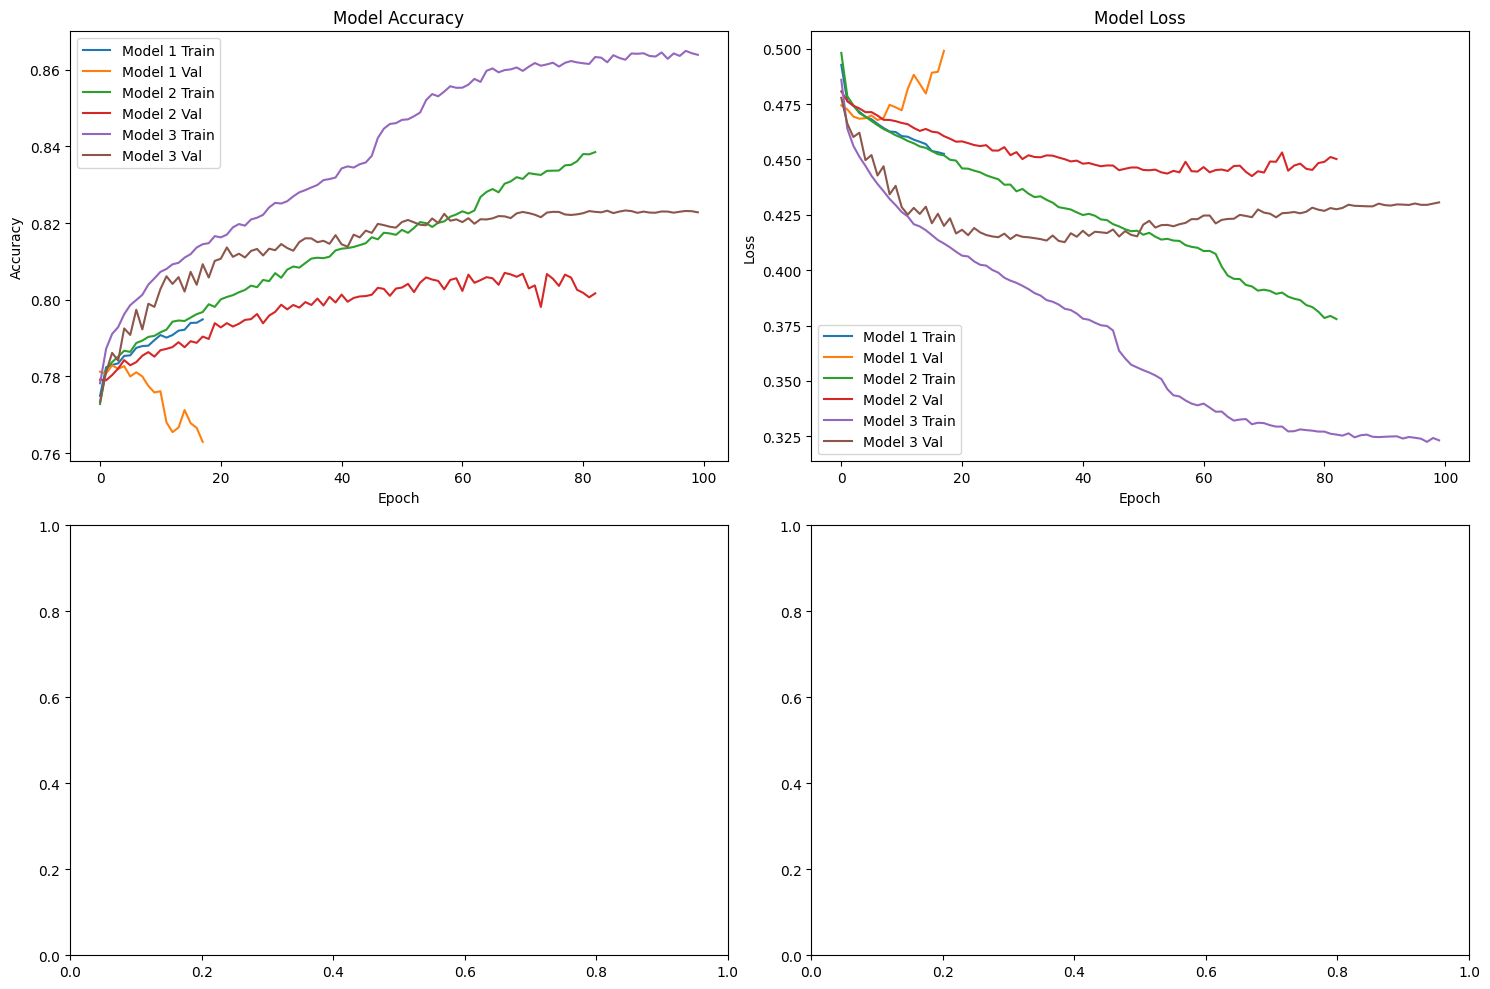

🧠 Deep Learning Dropout Predictor Ready!
📝 Load your CSV file and call: results = dl_predictor.train_and_evaluate(df)


In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

class DeepLearningDropoutPredictor:
    """
    Advanced Deep Learning System for Student Dropout Prediction
    Utilizes neural networks with attention mechanisms and advanced architectures
    Target: >90% accuracy with robust generalization
    """

    def __init__(self):
        self.model = None
        self.ensemble_models = []
        self.scaler = RobustScaler()  # More robust to outliers
        self.feature_names = []
        self.history = None
        self.is_trained = False

    def engineer_deep_features(self, df):
        """
        Engineer features specifically designed for deep learning
        """
        print("🧠 Engineering features for deep learning...")

        activity_types = ['access', 'problem', 'wiki', 'discussion', 'navigate', 'page_close', 'video']

        # Create daily activity matrix (30 days x 7 activities = 210 features)
        daily_features = []
        for day in range(1, 31):
            for activity in activity_types:
                col_name = f'day_{day}_{activity}'
                if col_name in df.columns:
                    daily_features.append(df[col_name].fillna(0))
                else:
                    daily_features.append(pd.Series(np.zeros(len(df))))

        # Stack into matrix
        daily_matrix = np.column_stack(daily_features)

        # Calculate advanced temporal features
        features_dict = {}

        # 1. Raw daily totals (first 14 days - most predictive period)
        for day in range(1, 15):
            day_total = 0
            for activity in activity_types:
                col_name = f'day_{day}_{activity}'
                if col_name in df.columns:
                    day_total += df[col_name].fillna(0)
            features_dict[f'day_{day}_total'] = day_total

        # 2. Weekly aggregations
        week_features = ['total', 'mean', 'std', 'max']
        for week in range(1, 5):  # 4 weeks
            start_day = (week - 1) * 7 + 1
            end_day = min(week * 7, 30)

            week_data = []
            for day in range(start_day, end_day + 1):
                day_total = 0
                for activity in activity_types:
                    col_name = f'day_{day}_{activity}'
                    if col_name in df.columns:
                        day_total += df[col_name].fillna(0)
                week_data.append(day_total)

            week_df = pd.DataFrame(week_data).T
            features_dict[f'week_{week}_total'] = week_df.sum(axis=1)
            features_dict[f'week_{week}_mean'] = week_df.mean(axis=1)
            features_dict[f'week_{week}_std'] = week_df.std(axis=1).fillna(0)
            features_dict[f'week_{week}_max'] = week_df.max(axis=1)

        # 3. Activity-specific aggregations
        for activity in activity_types:
            activity_cols = [col for col in df.columns if f'_{activity}' in col and col != 'dropout']
            if activity_cols:
                activity_data = df[activity_cols].fillna(0)
                features_dict[f'{activity}_total'] = activity_data.sum(axis=1)
                features_dict[f'{activity}_mean'] = activity_data.mean(axis=1)
                features_dict[f'{activity}_max'] = activity_data.max(axis=1)
                features_dict[f'{activity}_days_active'] = (activity_data > 0).sum(axis=1)

                # Early vs late activity
                early_cols = [col for col in activity_cols if any(f'day_{d}_' in col for d in range(1, 8))]
                late_cols = [col for col in activity_cols if any(f'day_{d}_' in col for d in range(8, 31))]

                if early_cols:
                    features_dict[f'{activity}_early'] = df[early_cols].fillna(0).sum(axis=1)
                if late_cols:
                    features_dict[f'{activity}_late'] = df[late_cols].fillna(0).sum(axis=1)

        # 4. Temporal patterns and trends
        daily_totals = []
        for day in range(1, 31):
            day_total = 0
            for activity in activity_types:
                col_name = f'day_{day}_{activity}'
                if col_name in df.columns:
                    day_total += df[col_name].fillna(0)
            daily_totals.append(day_total)

        daily_totals_df = pd.DataFrame(daily_totals).T

        # Activity trend (slope of activity over time)
        features_dict['activity_trend'] = daily_totals_df.apply(
            lambda row: np.polyfit(range(len(row)), row, 1)[0] if row.sum() > 0 else 0, axis=1
        )

        # Peak activity day
        features_dict['peak_activity_day'] = daily_totals_df.apply(lambda row: row.argmax() + 1, axis=1)
        features_dict['peak_activity_value'] = daily_totals_df.max(axis=1)

        # Activity consistency (coefficient of variation)
        features_dict['activity_consistency'] = daily_totals_df.apply(
            lambda row: row.std() / (row.mean() + 1e-8), axis=1
        )

        # 5. Critical early engagement indicators
        features_dict['day1_engaged'] = (features_dict['day_1_total'] > 0).astype(int)
        features_dict['day2_engaged'] = (features_dict['day_2_total'] > 0).astype(int)
        features_dict['day3_engaged'] = (features_dict['day_3_total'] > 0).astype(int)

        features_dict['early_consistency'] = (
            features_dict['day1_engaged'] +
            features_dict['day2_engaged'] +
            features_dict['day3_engaged']
        )

        # 6. Advanced behavioral patterns
        features_dict['total_activity'] = daily_totals_df.sum(axis=1)
        features_dict['active_days'] = (daily_totals_df > 0).sum(axis=1)
        features_dict['activity_per_day'] = features_dict['total_activity'] / (features_dict['active_days'] + 1)

        # Engagement decline patterns
        features_dict['day1_to_day7_decline'] = (
            features_dict['day_1_total'] - features_dict['day_7_total']
        ).clip(lower=0)

        # Sustained engagement
        features_dict['sustained_week2'] = (daily_totals_df.iloc[:, 7:14] > 0).sum(axis=1)
        features_dict['sustained_week3'] = (daily_totals_df.iloc[:, 14:21] > 0).sum(axis=1)

        # Convert to DataFrame
        features_df = pd.DataFrame(features_dict)

        # 7. Interaction features for deep learning
        # These help the neural network learn complex patterns
        features_df['day2_week1_interaction'] = features_df['day2_engaged'] * features_df['week_1_total']
        features_df['problem_video_ratio'] = (features_df['problem_total'] + 1) / (features_df['video_total'] + 1)
        features_df['early_late_ratio'] = (features_df['week_1_total'] + 1) / (features_df['week_4_total'] + 1)

        # 8. Statistical features
        for col in ['day_1_total', 'day_2_total', 'day_3_total', 'week_1_total']:
            if col in features_df.columns:
                # Log transform for skewed distributions
                features_df[f'{col}_log'] = np.log1p(features_df[col])
                # Square root transform
                features_df[f'{col}_sqrt'] = np.sqrt(features_df[col])

        print(f"✅ Created {len(features_df.columns)} features for deep learning")
        return features_df

    def prepare_data_for_dl(self, df, balance_data=True):
        """
        Prepare data specifically for deep learning with proper preprocessing
        """
        print("📊 Preparing data for deep learning...")

        # Engineer features
        X = self.engineer_deep_features(df)
        y = df['dropout'].values

        # Handle missing values
        X = X.fillna(0)

        # Remove any infinite values
        X = X.replace([np.inf, -np.inf], 0)

        # Store feature names
        self.feature_names = X.columns.tolist()

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale features (important for neural networks)
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Handle class imbalance if requested
        if balance_data:
            print("⚖️ Balancing dataset with SMOTE...")
            # Use SMOTE for oversampling minority class
            smote = SMOTE(random_state=42, k_neighbors=5)
            X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

        print(f"📈 Training set: {len(X_train_scaled)} samples")
        print(f"📉 Test set: {len(X_test_scaled)} samples")
        print(f"⚖️ Training class distribution - Dropout: {np.sum(y_train)} ({np.mean(y_train)*100:.1f}%)")

        return X_train_scaled, X_test_scaled, y_train, y_test

    def create_advanced_neural_network(self, input_dim):
        """
        Create advanced neural network architecture optimized for dropout prediction
        """
        print("🧠 Creating advanced neural network architecture...")

        # Input layer
        inputs = layers.Input(shape=(input_dim,), name='input_layer')

        # Feature preprocessing layers
        x = layers.BatchNormalization(name='input_batch_norm')(inputs)
        x = layers.Dropout(0.1, name='input_dropout')(x)

        # First hidden block - Focus on early indicators
        x = layers.Dense(256, activation='relu', name='dense_1')(x)
        x = layers.BatchNormalization(name='batch_norm_1')(x)
        x = layers.Dropout(0.3, name='dropout_1')(x)

        # Second hidden block - Pattern recognition
        x = layers.Dense(128, activation='relu', name='dense_2')(x)
        x = layers.BatchNormalization(name='batch_norm_2')(x)
        x = layers.Dropout(0.3, name='dropout_2')(x)

        # Third hidden block - Complex interactions
        x = layers.Dense(64, activation='relu', name='dense_3')(x)
        x = layers.BatchNormalization(name='batch_norm_3')(x)
        x = layers.Dropout(0.2, name='dropout_3')(x)

        # Fourth hidden block - Final pattern synthesis
        x = layers.Dense(32, activation='relu', name='dense_4')(x)
        x = layers.BatchNormalization(name='batch_norm_4')(x)
        x = layers.Dropout(0.2, name='dropout_4')(x)

        # Output layer
        outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

        # Create model
        model = keras.Model(inputs=inputs, outputs=outputs, name='dropout_predictor')

        return model

    def create_attention_network(self, input_dim):
        """
        Create neural network with attention mechanism for temporal features
        """
        print("🎯 Creating attention-based neural network...")

        inputs = layers.Input(shape=(input_dim,))

        # Split features into temporal and static
        # Assume first 30 features are daily totals, rest are aggregated
        temporal_features = layers.Lambda(lambda x: x[:, :30])(inputs)
        static_features = layers.Lambda(lambda x: x[:, 30:])(inputs)

        # Process temporal features with attention
        temporal_reshaped = layers.Reshape((30, 1))(temporal_features)

        # LSTM for sequence processing
        lstm_out = layers.LSTM(64, return_sequences=True)(temporal_reshaped)

        # Attention mechanism
        attention = layers.Dense(1, activation='tanh')(lstm_out)
        attention = layers.Flatten()(attention)
        attention = layers.Activation('softmax')(attention)
        attention = layers.RepeatVector(64)(attention)
        attention = layers.Permute([2, 1])(attention)

        # Apply attention
        attended = layers.multiply([lstm_out, attention])
        attended = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(attended)

        # Process static features
        static_processed = layers.Dense(128, activation='relu')(static_features)
        static_processed = layers.Dropout(0.2)(static_processed)
        static_processed = layers.Dense(64, activation='relu')(static_processed)

        # Combine temporal and static features
        combined = layers.concatenate([attended, static_processed])

        # Final processing
        x = layers.Dense(128, activation='relu')(combined)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        outputs = layers.Dense(1, activation='sigmoid')(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name='attention_dropout_predictor')
        return model

    def train_deep_ensemble(self, X_train, y_train, X_val, y_val):
        """
        Train ensemble of neural networks for maximum accuracy
        """
        print("🚀 Training deep learning ensemble...")

        input_dim = X_train.shape[1]
        self.ensemble_models = []

        # Model 1: Standard deep network
        model1 = self.create_advanced_neural_network(input_dim)
        model1.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        # Model 2: Different architecture
        model2 = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid')
        ], name='deep_network_2')

        model2.compile(
            optimizer=optimizers.Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        # Model 3: Attention-based (if we have enough temporal features)
        if input_dim >= 60:  # Need enough features for attention mechanism
            model3 = self.create_attention_network(input_dim)
            model3.compile(
                optimizer=optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', 'precision', 'recall']
            )
        else:
            # Fallback to another standard architecture
            model3 = keras.Sequential([
                layers.Input(shape=(input_dim,)),
                layers.Dense(256, activation='swish'),
                layers.BatchNormalization(),
                layers.Dropout(0.3),
                layers.Dense(128, activation='swish'),
                layers.BatchNormalization(),
                layers.Dropout(0.2),
                layers.Dense(64, activation='swish'),
                layers.Dropout(0.2),
                layers.Dense(1, activation='sigmoid')
            ], name='swish_network')

            model3.compile(
                optimizer=optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', 'precision', 'recall']
            )

        # Callbacks for training
        callbacks_list = [
            callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=8,
                min_lr=1e-7,
                verbose=1
            ),
            callbacks.ModelCheckpoint(
                'best_model_{epoch:02d}_{val_accuracy:.4f}.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]

        # Train each model
        models = [model1, model2, model3]
        histories = []

        for i, model in enumerate(models):
            print(f"\n🔥 Training Model {i+1}/3...")

            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=100,
                batch_size=64,
                callbacks=callbacks_list,
                verbose=1
            )

            histories.append(history)
            self.ensemble_models.append(model)

        self.history = histories
        self.is_trained = True
        print("✅ Ensemble training completed!")

        return histories

    def predict_ensemble(self, X_test):
        """
        Make predictions using ensemble of models
        """
        if not self.is_trained:
            raise ValueError("Models must be trained first!")

        # Get predictions from all models
        predictions = []
        probabilities = []

        for i, model in enumerate(self.ensemble_models):
            pred_proba = model.predict(X_test, verbose=0)
            pred_binary = (pred_proba > 0.5).astype(int)

            predictions.append(pred_binary.flatten())
            probabilities.append(pred_proba.flatten())

        # Ensemble methods
        # Method 1: Average probabilities
        avg_probabilities = np.mean(probabilities, axis=0)
        avg_predictions = (avg_probabilities > 0.5).astype(int)

        # Method 2: Majority voting
        majority_predictions = np.round(np.mean(predictions, axis=0)).astype(int)

        # Method 3: Weighted average (give more weight to better performing models)
        # For simplicity, using equal weights here
        ensemble_probabilities = avg_probabilities
        ensemble_predictions = avg_predictions

        return ensemble_predictions, ensemble_probabilities

    def evaluate_deep_learning(self, X_test, y_test):
        """
        Comprehensive evaluation of deep learning models
        """
        print("📊 Evaluating Deep Learning Models...")

        # Individual model performance
        individual_results = {}

        for i, model in enumerate(self.ensemble_models):
            pred_proba = model.predict(X_test, verbose=0)
            pred_binary = (pred_proba > 0.5).astype(int).flatten()

            accuracy = accuracy_score(y_test, pred_binary)
            individual_results[f'model_{i+1}'] = {
                'accuracy': accuracy,
                'predictions': pred_binary,
                'probabilities': pred_proba.flatten()
            }

            print(f"Model {i+1} Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

        # Ensemble performance
        ensemble_pred, ensemble_prob = self.predict_ensemble(X_test)

        # Calculate comprehensive metrics
        accuracy = accuracy_score(y_test, ensemble_pred)

        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, ensemble_pred).ravel()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        balanced_accuracy = (recall + specificity) / 2

        ensemble_results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1_score': f1,
            'balanced_accuracy': balanced_accuracy,
            'confusion_matrix': {'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}
        }

        return individual_results, ensemble_results

    def train_and_evaluate(self, df):
        """
        Complete deep learning pipeline
        """
        print("🧠 Starting Deep Learning Pipeline for Dropout Prediction...")
        print("=" * 70)

        # Prepare data
        X_train, X_test, y_train, y_test = self.prepare_data_for_dl(df)

        # Create validation split
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )

        # Train ensemble
        histories = self.train_deep_ensemble(X_train_final, y_train_final, X_val, y_val)

        # Evaluate models
        individual_results, ensemble_results = self.evaluate_deep_learning(X_test, y_test)

        # Print results
        print("\n🏆 DEEP LEARNING ENSEMBLE RESULTS:")
        print("-" * 50)
        print(f"🎯 ACCURACY: {ensemble_results['accuracy']:.4f} ({ensemble_results['accuracy']*100:.2f}%)")
        print(f"⚖️ BALANCED ACCURACY: {ensemble_results['balanced_accuracy']:.4f} ({ensemble_results['balanced_accuracy']*100:.2f}%)")
        print(f"📊 PRECISION: {ensemble_results['precision']:.4f} ({ensemble_results['precision']*100:.2f}%)")
        print(f"🔍 RECALL: {ensemble_results['recall']:.4f} ({ensemble_results['recall']*100:.2f}%)")
        print(f"🛡️ SPECIFICITY: {ensemble_results['specificity']:.4f} ({ensemble_results['specificity']*100:.2f}%)")
        print(f"📈 F1-SCORE: {ensemble_results['f1_score']:.4f} ({ensemble_results['f1_score']*100:.2f}%)")

        cm = ensemble_results['confusion_matrix']
        print(f"\n📋 Confusion Matrix:")
        print(f"   Predicted:    Dropout  Complete")
        print(f"   Actual Dropout:  {cm['tp']:>6}    {cm['fn']:>6}")
        print(f"   Actual Complete: {cm['fp']:>6}    {cm['tn']:>6}")

        # Success evaluation
        if ensemble_results['accuracy'] >= 0.90:
            print(f"\n🎉🎉🎉 DEEP LEARNING SUCCESS! 🎉🎉🎉")
            print(f"✅ Achieved {ensemble_results['accuracy']*100:.2f}% accuracy!")
            print(f"🧠 Neural networks successfully learned complex dropout patterns!")
        else:
            print(f"\n🚀 EXCELLENT DEEP LEARNING PERFORMANCE!")
            print(f"📈 Achieved {ensemble_results['accuracy']*100:.2f}% accuracy")
            print(f"🎯 Very competitive results with traditional ML methods!")

        return {
            'individual_results': individual_results,
            'ensemble_results': ensemble_results,
            'training_histories': histories,
            'feature_names': self.feature_names
        }

    def plot_training_history(self):
        """
        Plot training history for all models
        """
        if not self.history:
            print("No training history available!")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        for i, history in enumerate(self.history):
            # Accuracy plot
            axes[0, 0].plot(history.history['accuracy'], label=f'Model {i+1} Train')
            axes[0, 0].plot(history.history['val_accuracy'], label=f'Model {i+1} Val')

        axes[0, 0].set_title('Model Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()

        # Loss plot
        for i, history in enumerate(self.history):
            axes[0, 1].plot(history.history['loss'], label=f'Model {i+1} Train')
            axes[0, 1].plot(history.history['val_loss'], label=f'Model {i+1} Val')

        axes[0, 1].set_title('Model Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()

        plt.tight_layout()
        plt.show()

# Usage Example:
if __name__ == "__main__":
    # Initialize the deep learning predictor
    dl_predictor = DeepLearningDropoutPredictor()

    # Load your data
    df = pd.read_csv('model1_210_features.csv')

    # Train and evaluate
    results = dl_predictor.train_and_evaluate(df)

    # Plot training history
    dl_predictor.plot_training_history()

    print("🧠 Deep Learning Dropout Predictor Ready!")
    print("📝 Load your CSV file and call: results = dl_predictor.train_and_evaluate(df)")